In [1]:
import torch
from SPN import SPN
from matplotlib import pyplot as plt
import utils
import matplotlib.pyplot as plt 
from torchinfo import summary
import numpy as np
import LSE_net
import importlib
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
import Animator
from pathlib import Path
import GD
import ModelPass as mp
import inference
from Anneal import anneal
import pickle

### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [2]:
# !pip install nbformat --upgrade


Running on:  cuda
num_drones = 500	num_facilities = 50	dim = 2


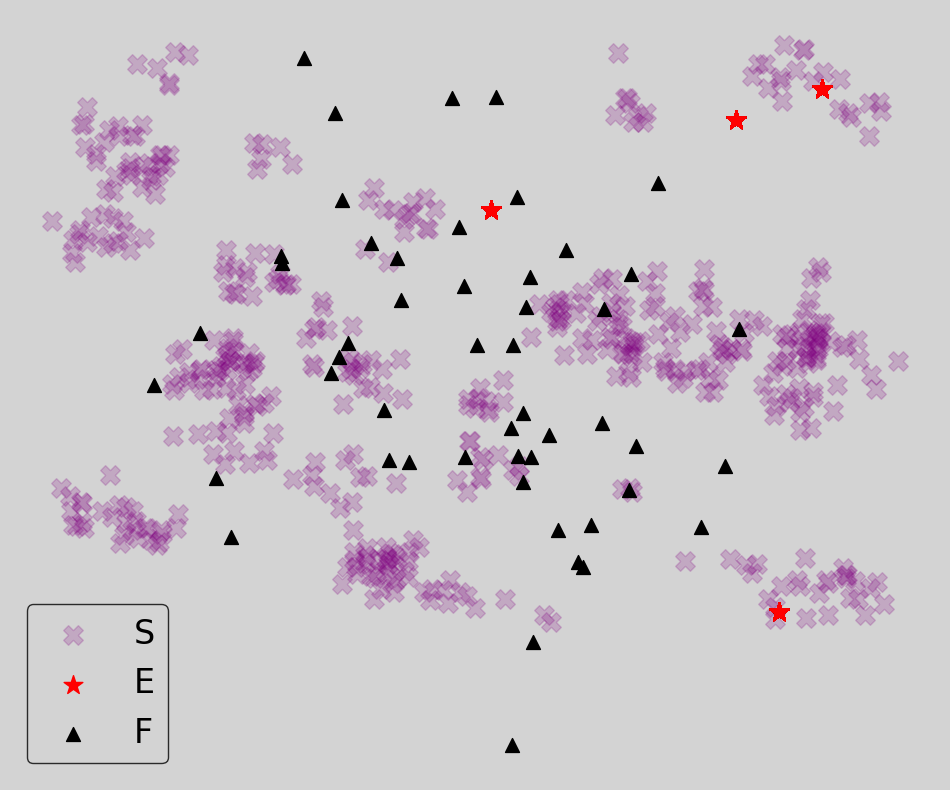

In [3]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

num_drones = 500
n_drone_clusters = 50
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 50
num_distinct_ends = 4
dim_ = 2
print(f"num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}")
# print(drone_cluster_split)
START_locs, F_base, END_locs = generate_dataset(
    num_drones, 
    n_drone_clusters, 
    drone_cluster_split, 
    num_facilities, 
    dim_, 
    device, 
    seed,
    drone_cluster_std_range=[0.02, 0.03], 
    F_noise_std=0.2,
    num_distinct_ends=num_distinct_ends
)

# torchFLPO_2_numpyFLPO(START_locs, END_locs, F_base, dim_, scale=1.0)

plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Load the VRP NET Module

In [4]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", spn.device)
print(summary(spn))

Model created.
VRP NET loaded on:  cuda
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│ 

### Load the LSE net module

In [5]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_19__15_47_58.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
D_max_range = lse_data['D_max_range']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'D_max_scale: {D_max_range}\nn_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

D_max_scale: 5.0
n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Optimization loop for a single beta
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

Using VRPNet and LSENet

In [42]:
# optim_iters = 200
# optim_step = 0.01
# b_min = 1e-3
# beta = 1e3
# tol = 1e-3

# Y_arr_adam, FreeEnergy_adam, G_adam = GD.Adam_at_beta(
#     F_base, START_locs, END_locs, spn, lse_net, optim_iters,
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True, return_list= True)

# F_base_GD1, FreeEnergy_GD1, G_GD1 = GD.GD_at_beta1(
#     F_base0, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)

# F_base_GD0, FreeEnergy_GD1, G_GD1 = GD.GD_at_beta0(
#     F_base0, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)



Using VRPNet and Path Sampling

In [6]:
optim_iters = 200
optim_step = 0.01
b_min = 1e4
beta = 1e4
tol = 0.001
n_path_samples = 8

F_base0_highbeta = F_base.clone().detach().requires_grad_(True)
F_base_sampling, FreeEnergy_sampling, G_sampling = GD.sampling_GD_at_beta_auto_diff(
    F_base0_highbeta,
    START_locs,
    END_locs,
    spn,
    n_path_samples=n_path_samples,
    beta=beta,
    stepsize=optim_step,
    iters=optim_iters,
    tol=tol,
    allowPrint=True
    )
    


iter: 0	FreeE:0.089	Norm_G: 0.132	tolY:0.095	mean_D_min:1.032e-01
iter: 1	FreeE:0.083	Norm_G: 0.096	tolY:0.081	mean_D_min:9.339e-02
iter: 2	FreeE:0.078	Norm_G: 0.089	tolY:0.073	mean_D_min:8.643e-02
iter: 3	FreeE:0.075	Norm_G: 0.078	tolY:0.067	mean_D_min:8.183e-02
iter: 4	FreeE:0.071	Norm_G: 0.103	tolY:0.061	mean_D_min:8.001e-02
iter: 5	FreeE:0.069	Norm_G: 0.087	tolY:0.058	mean_D_min:7.673e-02
iter: 6	FreeE:0.067	Norm_G: 0.070	tolY:0.056	mean_D_min:7.702e-02
iter: 7	FreeE:0.065	Norm_G: 0.067	tolY:0.054	mean_D_min:7.278e-02
iter: 8	FreeE:0.063	Norm_G: 0.065	tolY:0.052	mean_D_min:6.927e-02
iter: 9	FreeE:0.062	Norm_G: 0.064	tolY:0.049	mean_D_min:6.840e-02
iter: 10	FreeE:0.062	Norm_G: 0.064	tolY:0.046	mean_D_min:6.677e-02
iter: 11	FreeE:0.061	Norm_G: 0.063	tolY:0.043	mean_D_min:6.597e-02
iter: 12	FreeE:0.061	Norm_G: 0.061	tolY:0.040	mean_D_min:6.534e-02
iter: 13	FreeE:0.060	Norm_G: 0.061	tolY:0.039	mean_D_min:6.470e-02
iter: 14	FreeE:0.059	Norm_G: 0.050	tolY:0.039	mean_D_min:6.379e-02
iter:

### Save the high beta results (plotting done in plot_res.ipynb)

In [44]:
scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
file_path0 = "AAAI26_res/high_beta_res/" + scenario
# file_path0 = "AAAI26_res/low_beta_res/" + scenario

high_beta_res_data = {
    "START_locs":START_locs,
    "END_locs":END_locs,
    "F_base":F_base_sampling,
    "n_ends":num_distinct_ends,
    "F_base0":F_base0_highbeta,
    "optim_method":"sampling_GD_at_beta_auto_diff",
    "optim_iters":optim_iters,
    "optim_step":optim_step,
    "beta":beta,
    "optim_tol":tol,
    "n_path_samples":n_path_samples,
    "Free_energy_final":FreeEnergy_sampling,
    "Gradient_final":G_sampling
}

with open(file_path0, 'wb') as file:
    pickle.dump(high_beta_res_data, file)

### Annealing loop implementation
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

beta: 1.0000e-03	FreeE: -2564.3896	Grad: 1.9669e-01
beta: 1.0000e-02	FreeE: -256.0002	Grad: 1.0567e-01
beta: 1.0000e-01	FreeE: -25.1638	Grad: 1.0925e-01
beta: 1.0000e+00	FreeE: -2.1007	Grad: 1.2081e-01
beta: 1.0000e+01	FreeE: -0.1039	Grad: 2.4003e-02
beta: 1.0000e+02	FreeE: 0.0347	Grad: 5.2257e-03
beta: 1.0000e+03	FreeE: 0.0464	Grad: 9.8335e-04
beta: 1.0000e+04	FreeE: 0.0465	Grad: 2.1121e-03


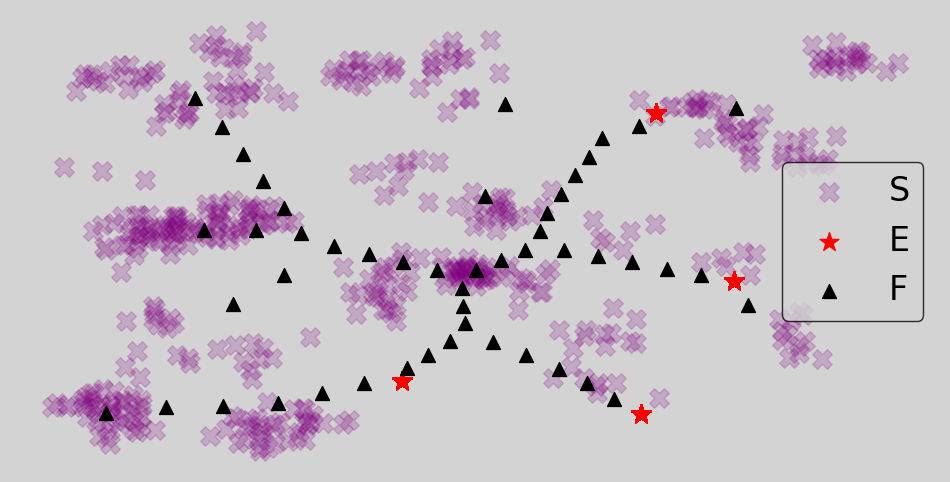

In [45]:
beta_min = 1e-3 
beta_max = 1e4
beta_grow = 10
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = "sampling_auto_diff"
tol = 0.001
n_path_samples = 8

F_base0_anneal = F_base.clone().detach().requires_grad_(True)
Y_arr, b_arr, F_arr = anneal( 
        F_base0_anneal, 
        START_locs, 
        END_locs, 
        spn, 
        lse_net, 
        optim_iters, 
        optim_step, 
        beta_min, 
        beta_max, 
        beta_grow, 
        D_max_range=D_max_range, 
        tol=tol, 
        optimizer_name=optim_name, 
        n_path_samples=n_path_samples, 
        allowPrint=True 
    ) 

plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (12,6))


### Save the annealing results (plotting done in plot_res.ipynb)

In [46]:
file_path1 = "AAAI26_res/annealing_res/" + scenario
print(f'filepath: {file_path1}')

annealing_res_data = {
    "START_locs":START_locs,
    "END_locs":END_locs,
    "Y_arr":Y_arr,
    "b_arr":b_arr,
    "F_arr":F_arr,
    "F_bas0":F_base0_anneal,
    "optim_method":optim_name,
    "optim_iters":optim_iters,
    "optim_step":optim_step,
    "optim_tol":tol,
    "n_path_samples":n_path_samples
}

with open(file_path1, 'wb') as file:
    pickle.dump(annealing_res_data, file)

filepath: AAAI26_res/annealing_res/N500_M50_ends4_seed3


### Animation results moved to plot_res.ipynb